In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import json
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from PIL import Image, ImageDraw, ImageOps
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torchvision.transforms import v2
from torchvision import models
import matplotlib.pyplot as plt
import os
import sys
import random

import utils

Подготовка датасета

In [3]:
TRAIN_DATA_DIR = 'data/train_images/train_images'
TEST_DATA_DIR = 'data/test_images/test_images'

In [4]:
with open('data/usdc_train.json', 'r') as file:
    train_data = json.load(file)

In [5]:
classes_dict = {}
for sample in train_data['categories']:
    classes_dict[sample['id']-1] = sample['name']
del classes_dict[-1]
classes_dict 

{0: 'biker',
 1: 'car',
 2: 'pedestrian',
 3: 'trafficLight',
 4: 'trafficLight-Green',
 5: 'trafficLight-GreenLeft',
 6: 'trafficLight-Red',
 7: 'trafficLight-RedLeft',
 8: 'trafficLight-Yellow',
 9: 'trafficLight-YellowLeft',
 10: 'truck'}

In [6]:
classes_colors = ['red', 'blue', 'green', 'violet', 'gold', 'brown',
                  'darkseagreen', 'aquamarine', 'olive', 'plum', 'sandybrown']

In [7]:
annotations_df = pd.DataFrame(train_data['annotations'])
annotations_df = annotations_df.drop(columns=['id', 'segmentation', 'iscrowd', 'confidence', 'score'])
annotations_df.head()

,image_id,category_id,bbox,area
0,5,2,"[196, 234, 20.266666666666666, 24.74666666666667]",501.532444
1,5,2,"[247, 236, 16.53333333333333, 24.74666666666667]",409.144889
2,5,2,"[265, 234, 20.8, 23.893333333333334]",496.981333
3,5,2,"[267, 237, 15.466666666666667, 17.066666666666...",263.964444
4,5,2,"[305, 233, 78.93333333333334, 75.94666666666667]",5994.723556


In [8]:
annotations_df['category_id'].unique()

array([ 2,  8,  1,  7, 11,  3,  4,  5,  9,  6, 10])

In [9]:
annotations_df['category_id'] = annotations_df['category_id'].apply(lambda x: x - 1)

In [10]:
images_df = pd.DataFrame(train_data['images'])
images_df = images_df.drop(columns=['license', 'height', 'width', 'date_captured'])
images_df = images_df.rename(columns={'id' : 'image_id'})
images_df.head()

,image_id,file_name
0,5,1478020898717725646_jpg.rf.68EjFVQdDWrB0SW6qVl...
1,14,1478020650710690845_jpg.rf.68NUjFyrbU9Nsyt3ika...
2,22,1478898975867837103_jpg.rf.6847BekYxQ4SlhtvjlE...
3,57,1478895940606118436_jpg.rf.68xNq7HL27EKmRnrGgp...
4,58,1478896447910420804_jpg.rf.68xeyVz6sbVFpLVku7W...


In [11]:
train_annotations = utils.create_dataset(images_df, annotations_df)

In [12]:
file_names = [file_name["file_name"] for file_name in train_annotations]

In [13]:
class DetectionDataset(Dataset):
    def __init__(self, annotations: dict, img_dir: str, transform=None):
        self.annotations = annotations
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        sample = self.annotations[idx]
        img_path = os.path.join(TRAIN_DATA_DIR, sample['file_name'])
        
        image = Image.open(img_path)
        
        bboxes = []
        labels = []
        for obj in sample['annotations']:
            bboxes.append(obj['bbox'])
            labels.append(obj['class'])
            
        bboxes = torch.tensor(bboxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        
        w_old, h_old = image.size
        
        if self.transform: 
            image, bboxes = self.transform.forward(image, bboxes)
            
        return image, {'bboxes' : bboxes, 'labels' : labels}

In [14]:
train_dataset = DetectionDataset(train_annotations, TRAIN_DATA_DIR)

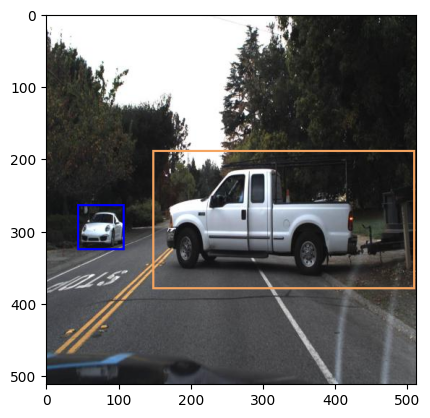

In [15]:
image = train_dataset[2323][0]
bboxes = train_dataset[2323][1]['bboxes']
labels = train_dataset[2323][1]['labels']

utils.plot_image(image, bboxes, labels, classes_colors)

Добавление Local Contrast Normalization и различных трансформаций

In [16]:

class BasicTransform:
    def __init__(self, resize=None, lcn=False):
        self.resize = resize
        self.lcn = lcn
        
    def forward(self, img, bboxes):
        resize = self.resize
        lcn = self.lcn
        
        if random.uniform(0, 1) < 0.5:
            img = ImageOps.mirror(img)
            for i, bbox in enumerate(bboxes):
                x, y, w, h = bbox.tolist()
                new_x = img.size[0] - x - w
                bboxes[i] = torch.tensor([new_x, y, w, h])
                
        
        angle = random.randint(-30, 30)
        r_image = img.rotate(angle, expand=1)
        for i, bbox in enumerate(bboxes):
            bboxes[i] = torch.tensor(utils.rotate_bbox(bbox, img.size, r_image.size, angle),
                                    dtype=torch.float32)
        
        r_image = v2.ColorJitter(brightness=(0.4, 2), contrast=(1, 6),
                saturation=(0, 2.5), hue=(-0.25,0.25))(r_image)
        
        r_image = v2.RandomInvert(0.3)(r_image)
        
        if resize:
            w_old, h_old = r_image.size
            r_image = transforms.Resize(resize)(r_image)
            w_new, h_new = r_image.size
            scale_x = w_new / w_old
            scale_y = h_new / h_old
            for i, bbox in enumerate(bboxes):
                x_old, y_old, w_old, h_old = bbox
                bboxes[i] = torch.tensor([x_old * scale_x, y_old * scale_y, w_old * scale_x, h_old * scale_y],
                                            dtype=torch.float32)
        
        r_image = transforms.ToTensor()(r_image)
        
        if lcn:
            r_image = utils.LocalContrastNorm(kernel_size=7)(r_image)
        
        return r_image, bboxes

In [17]:
train_dataset_tr = DetectionDataset(train_annotations, TRAIN_DATA_DIR, transform=BasicTransform(lcn=False, resize=(512, 512)))

In [71]:
train_dataset_tr[0]

(tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]),
 {'bboxes': tensor([[373.4101, 300.9474,  29.9248,  31.5646],
          [333.4760, 328.1795,  26.6916,  29.6979],
          [313.1924, 335.4474,  29.9600,  31.0922],
          [317.5792, 339

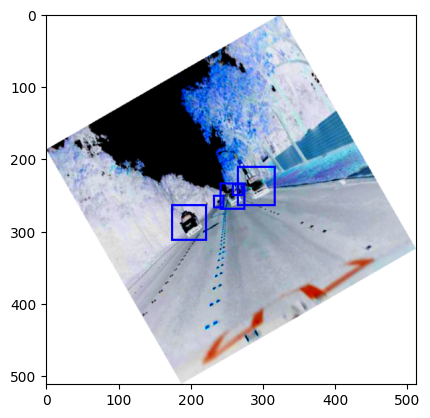

In [18]:
img, dct = train_dataset_tr[5555]
img = transforms.functional.to_pil_image(img)
bboxes = dct['bboxes']
labels = dct['labels']
utils.plot_image(img, bboxes, labels, classes_colors)

In [ ]:
box = torch.tensor([1, 7, 3 , 4])
a = torch.tensor([[0, 1, 5, 6], 
                  [6, 7, 8, 9]])
torch.where(a[: 0] > box[0], 1, 0)
a[:]

tensor([], size=(0, 4), dtype=torch.int64)

In [160]:
a = torch.randn((2, 1, 5, 3)).squeeze(dim=1)
soft_max = nn.Softmax(dim=2)
print(a)
print(a.size())
mask = a < 0.0
print(mask)
print(mask.any(dim=2))
indices = mask.any(dim=2)
print(indices)
print(a[:, indices].size())
# print(a[indices])

tensor([[[-0.0198,  1.1037,  1.3818],
         [-0.5584,  0.4770,  2.5717],
         [-1.3840, -0.0129, -1.0340],
         [-0.1738, -0.0584, -1.1828],
         [ 1.0053,  0.7825,  1.3139]],

        [[ 0.8852,  0.9308, -0.3024],
         [-0.1231,  0.0975,  0.5024],
         [-1.2837, -0.7726,  1.5619],
         [ 0.1316,  1.0749,  0.1594],
         [-0.3410, -0.2769,  1.4466]]])
torch.Size([2, 5, 3])
tensor([[[ True, False, False],
         [ True, False, False],
         [ True,  True,  True],
         [ True,  True,  True],
         [False, False, False]],

        [[False, False,  True],
         [ True, False, False],
         [ True,  True, False],
         [False, False, False],
         [ True,  True, False]]])
tensor([[ True,  True,  True,  True, False],
        [ True,  True,  True, False,  True]])
tensor([[ True,  True,  True,  True, False],
        [ True,  True,  True, False,  True]])


IndexError: The shape of the mask [2, 5] at index 0 does not match the shape of the indexed tensor [2, 5, 3] at index 1

In [217]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(3)
        self.conv2 = nn.Conv2d(16, 32, 3)
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        return x

class DetectionHead(nn.Module):
    def __init__(self, in_channels, num_classes, frames: int=100):
        super(DetectionHead, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=1, padding=((frames - 56) // 2, 0), dilation=(1, 1), kernel_size=(1, 53))
        self.fc = nn.Linear(in_channels, 256)
        self.soft_max = nn.Softmax(dim=2)
        self.cls_layer = nn.Linear(4, num_classes)
        self.reg_layer = nn.Linear(num_classes, frames)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = x.squeeze(dim=1)
        logits = self.soft_max(self.cls_layer(x))
        bboxes = self.relu(self.reg_layer(x.mT.bmm(logits)))
        return logits, bboxes.mT
    
class ObjectDetectionModel(nn.Module):
    def __init__(self, num_classes, frames: int=100):
        super(ObjectDetectionModel, self).__init__()
        self.feature_extractor = FeatureExtractor()
        self.detection_head = DetectionHead(in_channels=32, num_classes=num_classes, frames=frames)

    def forward(self, x):
        features = self.feature_extractor(x)
        logits, bboxes = self.detection_head(features)
        return logits, bboxes
    def predict(self, x, threshold: float=0.5):
        logits, bboxes = self.forward(x)
        mask_logits = logits > threshold
        indices = mask_logits.any(dim=2)
        labels = []
        bboxes_pred = []
        for i in range(x.shape[0]):
            if logits[i][indices[i]].numel() != 0:
                labels.append(torch.argmax(logits[i][indices[i]], dim=1))
                bboxes_pred.append(bboxes[i][indices[i]])
        return {"labels": labels, "bboxes": bboxes_pred}

In [24]:
def collate_fn(batch):
    """
    Объединяет список кортежей (image, target) в батч.
    """
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    return torch.stack(images), targets

train_dataloader = DataLoader(train_dataset_tr, batch_size=8, shuffle=True, collate_fn=collate_fn)

In [219]:
import torch.nn.functional as F

def custom_loss(cls_outs, reg_outs, targets):
    cls_loss = 0.0
    reg_loss = 0.0
    num_samples = len(targets) 

    for i in range(num_samples):
        labels_ind = targets[i]["labels"].long()
        bboxes = targets[i]["bboxes"].float()
        indices_use = []
        current_cls_outs = torch.tensor(cls_outs[i], requires_grad=True)
        for j, label in enumerate(labels_ind):
            label_tensor = torch.zeros(11)
            label_tensor[label] = 1
            preds = torch.tensor([F.cross_entropy(logits, label) for i, logits in enumerate(current_cls_outs) if i not in indices_use], requires_grad=True)
            cls_loss += torch.min(preds)
            best_bbox = torch.argmin(preds)
            reg_loss += F.smooth_l1_loss(bboxes[j], reg_outs[i][best_bbox])
            indices_use.append(best_bbox)
            # current_cls_outs[best_bbox] = torch.zeros_like(current_cls_outs[best_bbox], requires_grad=True)
    total_loss = (cls_loss + reg_loss) / num_samples
    return total_loss

In [193]:
model = ObjectDetectionModel(num_classes=12, frames=100)
# head = DetectionHead(in_channels=32, num_classes=12, frames=56)
for i in train_dataloader:
    # print(i[1])
    logits, bboxes = model(i[0])
    print("logits", logits.size())
    print("bboxes", bboxes.size())
    pred = model.predict(i[0], threshold=0.11)
    print(pred["labels"])
    print(pred["bboxes"])
    print(custom_loss(logits, bboxes, i[1]))
    # print(head(x).size())
    break

logits torch.Size([8, 100, 12])
bboxes torch.Size([8, 100, 4])
[tensor([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11]), tensor([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11]), tensor([11, 11, 11, 11, 11, 11, 11, 

In [76]:
model = ObjectDetectionModel(num_classes=12)
for i in train_dataloader:
    # print(i[1])
    cls_out, reg_out = model(i[0])
    print(custom_loss(cls_out, reg_out, i[1]))
    break

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:889: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


tensor(1226.9231, grad_fn=<DivBackward0>)


In [90]:
len(train_dataset_tr)

12000

In [ ]:
model = ObjectDetectionModel(num_classes=11, frames=100)
import warnings 
torch.autograd.set_detect_anomaly(True)
warnings.filterwarnings('ignore')
optimizer = optim.Adam(model.parameters(), lr=0.001)
losses = []
for epoch in range(10):
    step = 0
    for images, targets in train_dataloader:
        optimizer.zero_grad()
        cls_out, reg_out = model(images)
        loss = custom_loss(cls_outs=cls_out, reg_outs=reg_out, targets=targets)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        sys.stderr.write("avg_loss: {} loss: {} step {}/{}\n".format(np.mean(losses), loss.item(), step + 1, len(train_dataset_tr)//8))
        sys.stderr.flush()
        step += 1
        # print(f"Epoch {epoch + 1}, loss: {loss.item()}")
    print(f"Epoch {epoch + 1}, loss: {loss.item()}")

avg_loss: 906.4425659179688 loss: 906.4425659179688 step 1/1500
avg_loss: 889.1849670410156 loss: 871.9273681640625 step 2/1500
avg_loss: 978.0392456054688 loss: 1155.747802734375 step 3/1500
avg_loss: 945.1553955078125 loss: 846.5038452148438 step 4/1500
avg_loss: 975.0669921875 loss: 1094.71337890625 step 5/1500
avg_loss: 930.8188781738281 loss: 709.5783081054688 step 6/1500
avg_loss: 930.7154453822544 loss: 930.0948486328125 step 7/1500
avg_loss: 921.3260345458984 loss: 855.6001586914062 step 8/1500
avg_loss: 921.7732204861111 loss: 925.3507080078125 step 9/1500
avg_loss: 914.2935852050781 loss: 846.9768676757812 step 10/1500
avg_loss: 892.7174294211648 loss: 676.9558715820312 step 11/1500
avg_loss: 873.7026926676432 loss: 664.5405883789062 step 12/1500
avg_loss: 885.8555861253005 loss: 1031.6903076171875 step 13/1500
avg_loss: 887.6516854422433 loss: 911.0009765625 step 14/1500
avg_loss: 907.2150268554688 loss: 1181.101806640625 step 15/1500
avg_loss: 905.8958778381348 loss: 886.10

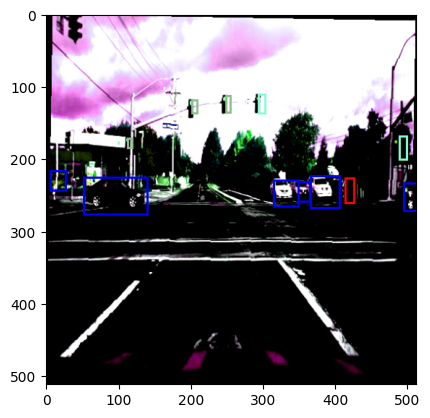

In [106]:
# train_dataset_tr[23]
img, dct = train_dataset_tr[1]
img = transforms.functional.to_pil_image(img)
bboxes = dct['bboxes']
labels = dct['labels']
utils.plot_image(img, bboxes, labels, classes_colors)

In [110]:
cls_out, reg_out = model(train_dataset_tr[:8][0])

TypeError: list indices must be integers or slices, not str

In [113]:
images = []
for i in range(8):
    images.append(train_dataset_tr[i][0].numpy())
images = torch.tensor(images)

In [116]:
cls_outs, reg_outs = model(images)

In [163]:
label = torch.argmax(cls_outs, dim=1)[[0, 2, 4]]
bbox = reg_outs[[0, 2, 4]]

In [137]:
for i in bbox.resize(1, 4):
    a, b, c, d = i
a

tensor(159.2659, grad_fn=<UnbindBackward0>)

In [164]:
bbox

tensor([[159.2659, 236.6120,  25.9514,  83.6213],
        [469.9258, 511.6923, 118.1376,  37.9789],
        [256.1172, 227.6984,  26.6666,  36.5385]], grad_fn=<IndexBackward0>)

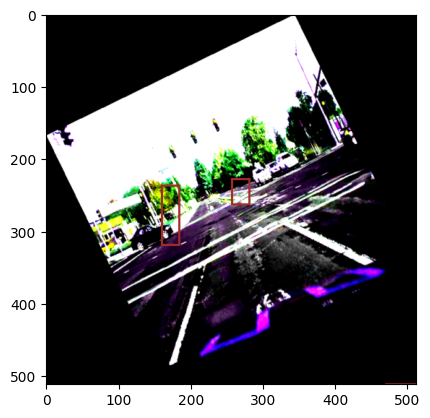

In [165]:
img, dct = train_dataset_tr[1]
img = transforms.functional.to_pil_image(img)
# bboxes = dct['bboxes']
# labels = dct['labels']
utils.plot_image(img, bbox, label, classes_colors)